# Lab 6
Lucas Street, 1874989

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from hera_cal.io import HERAData

In [14]:
filename = '../Lab 5/zen.2458108.57290.HH.uvh5'
hd = HERAData(filename)

def get_spectrogram(hd, selected_times, freq_channels, *args, filter_dupes=False, **kwargs):
    hd.read(times=selected_times, freq_chans=freq_channels)
    if filter_dupes:
        pairs = np.array(hd.get_antpairs())
        no_dupe_pairs = pairs[pairs[:, 0] != pairs[:, 1]]
        hd.select(bls=list(map(tuple, no_dupe_pairs)))
    data = hd.get_data(*args, **kwargs)
    times = hd.get_times(*args, **kwargs)
    times -= times[0]
    freqs_mhz = hd.freq_array.flatten() / 1e6
    return pd.DataFrame(data, times, freqs_mhz), times, freqs_mhz

def plot_spectrogram(freqs, times, data, colorbar=True):
    # Handle case where we only have one unique time
    single_time = False
    if times[0] == times[-1]:
        single_time = True
        times = [0, 1]
    
    plt.imshow(np.abs(data), origin='bottom', extent=(freqs[0], freqs[-1], times[0], times[-1]), aspect='auto')
    
    if single_time:
        # No need for a time axis if we only have one time
        plt.gca().get_yaxis().set_visible(False)
    
    plt.ylabel('Time (JD)')
    plt.xlabel('Frequency (MHz)')
    if colorbar:
        cbar = plt.colorbar()
        cbar.set_label('Amplitude')
    
def plot_avg_amplitudes(freqs, times, data):
    avg_amplitudes = np.mean(np.abs(data), axis=0)
    plt.plot(freqs, avg_amplitudes)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude')
    plt.xlim(freqs[0], freqs[-1])
    
def plot_histogram(times, frequency_channels, max_amplitude=0.4, polarization='XX'):
    all_antenna_data, _, _ = get_spectrogram(hd, times, frequency_channels, polarization)
    hist_data = np.abs(np.array(all_antenna_data).flatten())
    hist_data = hist_data[np.abs(hist_data) < max_amplitude]
    # print(len(hist_data))
    plt.title(f"Background distribution for time {times.round(4)}")
    plt.xlabel('Amplitude')
    plt.ylabel('Probability Density')
    plt.hist(hist_data, bins=100, density=True);
    return hist_data

def plot_lognormal_fit(hist_data, max_amplitude=0.4):
    sigma, mean, scale = stats.lognorm.fit(hist_data)
    dist = stats.lognorm(sigma, mean, scale)
    x = np.linspace(0, max_amplitude, 1000)
    y = dist.pdf(x)
    plt.plot(x, y, linewidth=4, alpha=0.8)
    plt.yscale('log')
    plt.xlim(0, max_amplitude)
    plt.ylim(1e-4)
    plt.legend(['Lognormal fit', 'Background'])
    print(f"Lognormal: mu: {mean}, sigma: {sigma}, s: {scale}")
    return sigma, mean, scale

## Problem 1

Let's find a model for the background distribution of the HERA telescope data. A plot from the previous lab is shown below, where the average visibility amplitude versus observed frequency is shown across all baselines for the first time interval, where redundant baselines (consisting of an antenna paired with itself) are removed.

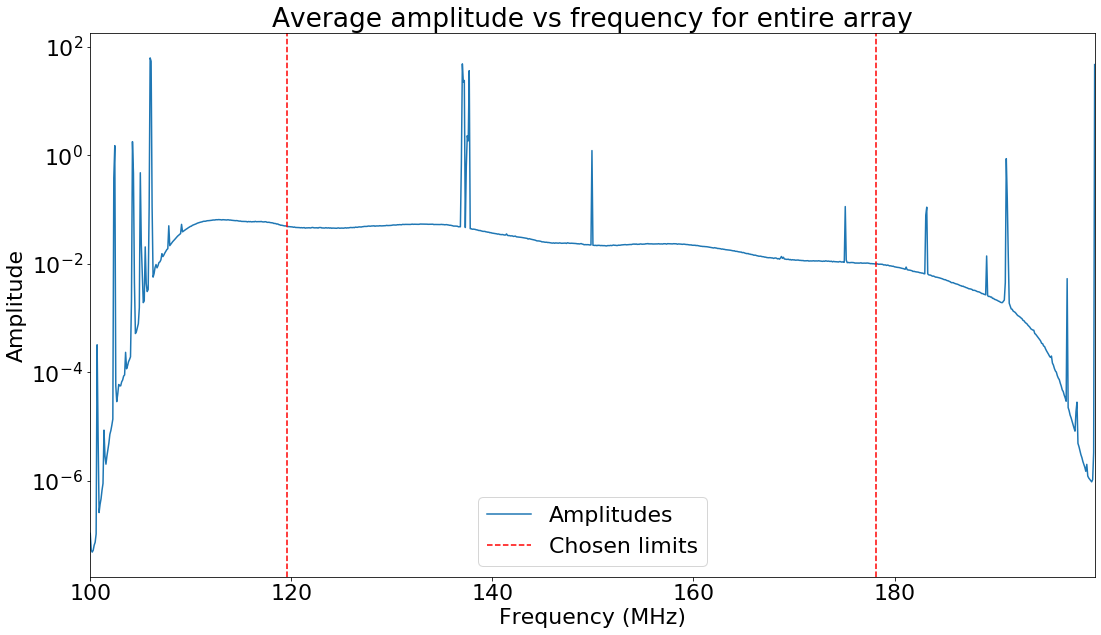

In [123]:
freq_start_index = 200
freq_end_index = 800

data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:1], np.arange(0, 1024), 'XX', filter_dupes=True)
plot_avg_amplitudes(freqs_mhz, times, data)
plt.axvline(hd.freqs[freq_start_index] / 1e6, 0, 1, color='r', linestyle='--')
plt.axvline(hd.freqs[freq_end_index] / 1e6, 0, 1, color='r', linestyle='--')
plt.title('Average amplitude vs frequency for entire array')
plt.yscale('log')
plt.legend(['Amplitudes', 'Chosen limits']);

The left and right edges of the plot slope sharply downward; this might be due to the geometry of the antennae or the sensitivity of the recording device, but in any case we'll consider this sharp sloping to be separate from our background, which we take to be the flat plateau that composes the majority of the plot. We don't need the entire plateau, but we'll take a good chunk of it (delimited by the red dashed lines) and plot the distribution of amplitudes.

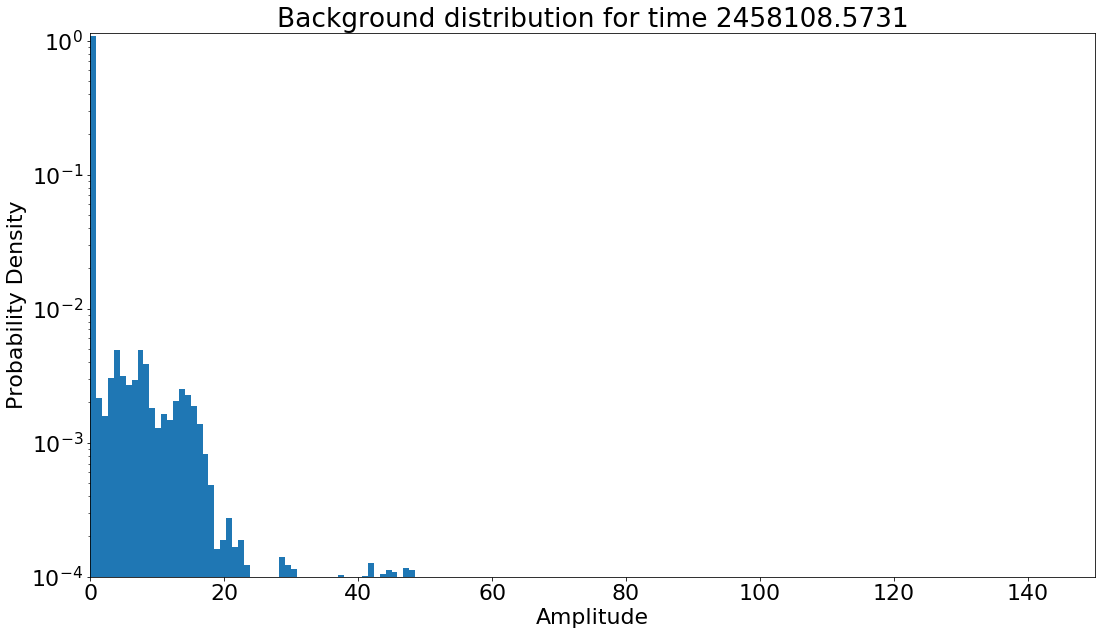

In [119]:
time = hd.times[1]
freq_channels = np.arange(freq_start_index, freq_end_index)

plot_histogram(time, freq_channels, max_amplitude=150, polarization='XX')
plt.xlim(0, 150)
plt.ylim(1e-4, None)
plt.yscale('log')

This looks fairly messy, and we get lots of signal contamination from the RFI signals represented by large spikes in the amplitude versus frequency plot. From inspection of the previous plot, the majority of the plateau looks to be hovering somewhere less than 0.1, so we'll zoom in our histogram to amplitude values less than 0.4 just to be safe.

Lognormal: mu: -0.0023704080407416666, sigma: 0.8758018396888612, s: 0.02249151176545202


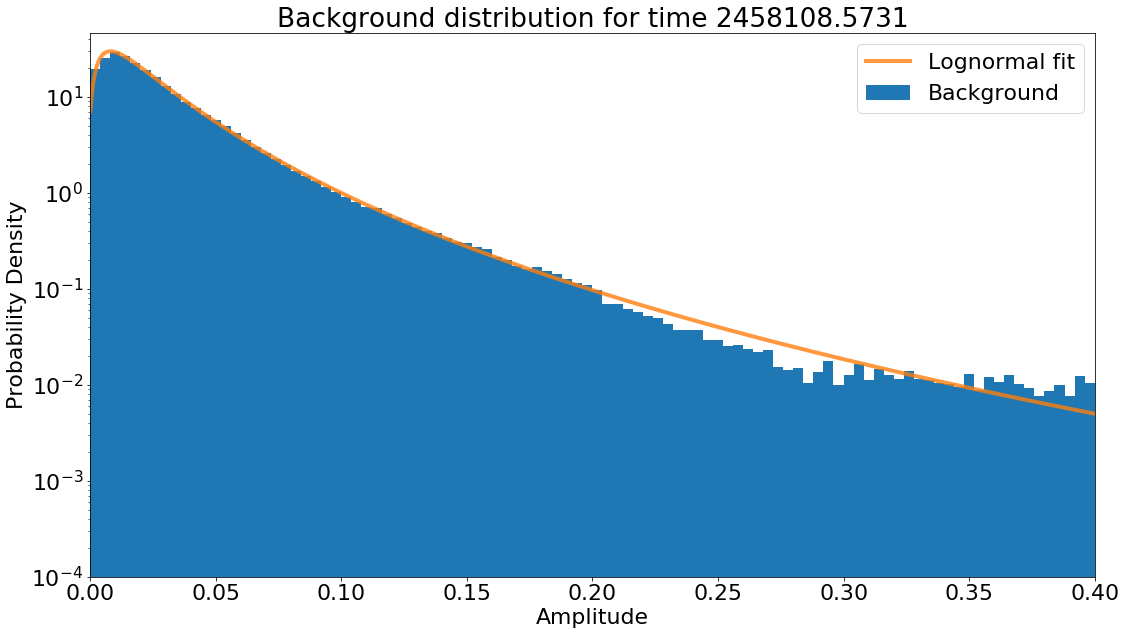

In [94]:
hist_data = plot_histogram(time, freq_channels, max_amplitude=0.4, polarization='XX')
sigma, mean, scale = plot_lognormal_fit(hist_data, max_amplitude=0.4)

A lognormal distribution is fitted to this data and appears to model the observed background fairly well, even past 0.1 units of amplitude. The PDF we'll use to model the background is $P(x|\mu, \sigma, s) = \frac{1}{\sigma (x - \mu) \sqrt{2\pi}} \exp\left(-\frac{\log^2\left(\frac{x - \mu}{s}\right)}{2\sigma^2}\right)$ where $\mu = -0.0024, \sigma = 0.8758, s = 0.0225$.

What is the amplitude at or above which we observe events with a significance of $5\sigma$?

In [112]:
dist = stats.lognorm(sigma, mean, scale)
dist.ppf(stats.norm.cdf(5))

1.791529380056979

This is our sensitivity threshold: seeing an amplitude of about 1.79 or more gives us statistically significant events.

## Problem 2

Now we will inject some fake signals into our background data to simulate the presence of some high-significance event. We'll pick a signal strength of 100, much greater than our $5\sigma$ threshold, and add it to some fraction of our background points. We'll call this fraction the _injection rate_, and we'll set it equal to 0.25. We will choose some large number of randomly-selected background points to analyze; to avoid melting my computer, I'll choose 50,000 points.

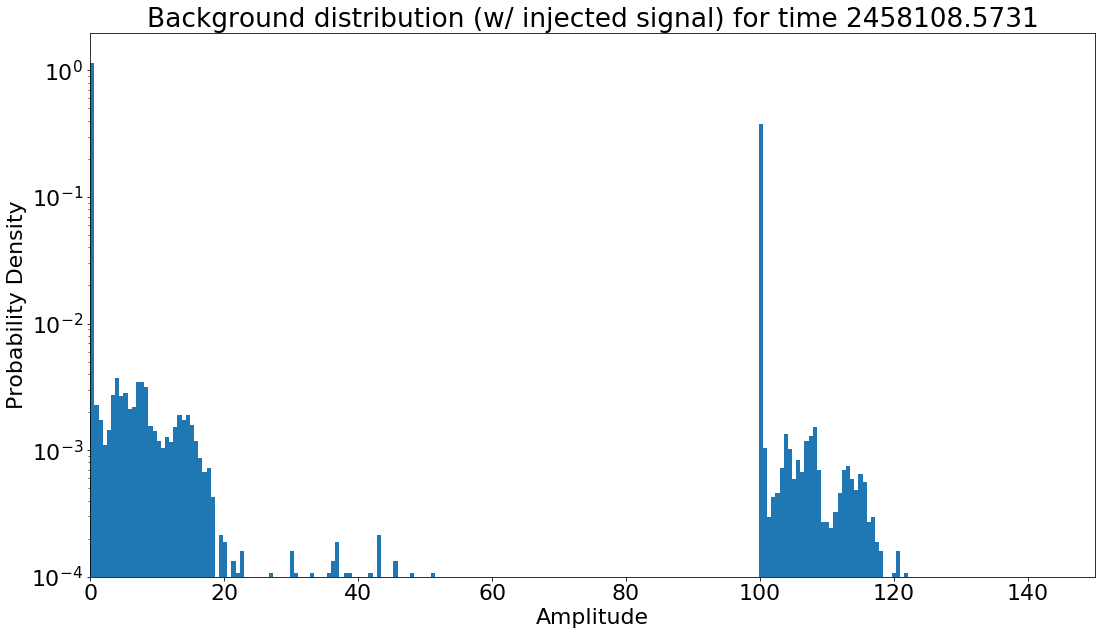

In [173]:
signal_strength = 100
injection_rate = 0.25
num_background_points = 60_000

background_data, _, _ = get_spectrogram(hd, time, freq_channels, 'XX')
background_data_flat = np.abs(np.array(background_data).flatten())
random_indices = np.random.choice(len(background_data_flat), num_background_points, replace=False)
background_data_flat = background_data_flat[random_indices]

signal = (np.random.rand(background_data_flat.size) < injection_rate) * signal_strength
background_injected = background_data_flat + signal

plt.title(f"Background distribution (w/ injected signal) for time {time.round(4)}")
plt.xlabel('Amplitude')
plt.ylabel('Probability Density')
plt.hist(background_injected, bins=300, density=True)
plt.yscale('log')
plt.xlim(0, 150)
plt.ylim(1e-4, None);

## Problem 3

In [174]:
signal_locations = (np.random.rand(600, len(background_data_flat)) < injection_rate)
signal_strengths = np.linspace(0, 200, 600)
_, signal_strengths_grid = np.meshgrid(signal_locations[0, :], signal_strengths)
signal = signal_locations * signal_strengths_grid

observed = background_data_flat + signal

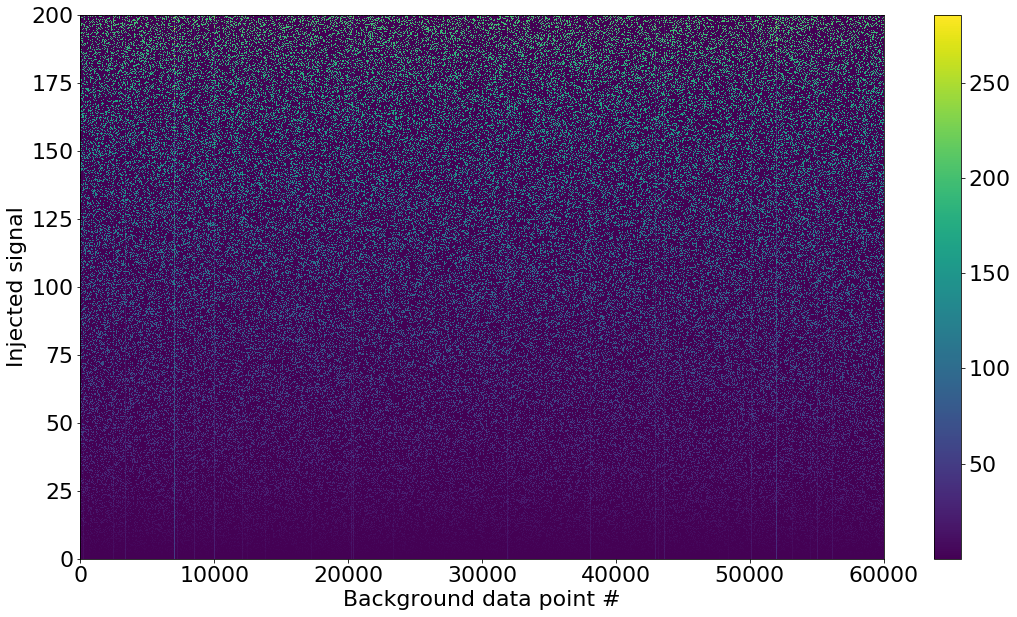

In [175]:
plt.xlabel('Background data point #')
plt.ylabel('Injected signal')
plt.imshow(observed, origin='bottom', extent=(0, num_background_points, signal_strengths[0], signal_strengths[-1]))
plt.colorbar()
plt.gca().set_aspect('auto');

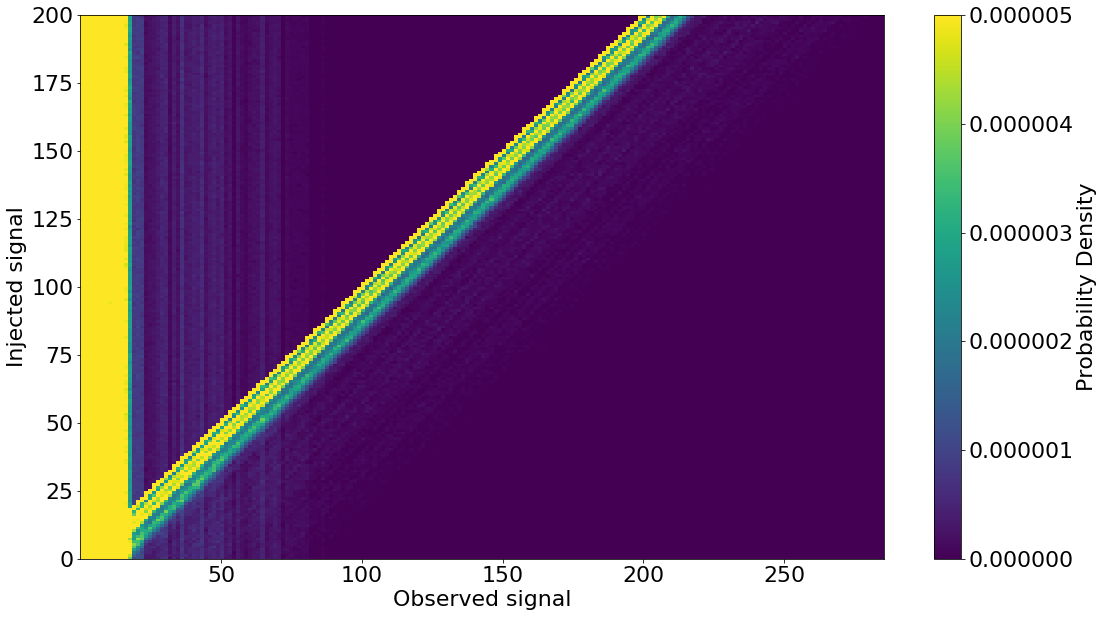

In [176]:
plt.xlabel('Observed signal')
plt.ylabel('Injected signal')
plt.hist2d(observed.flatten(), signal_strengths_grid.flatten(), bins=200, density=True, vmax=5e-6)
cbar = plt.colorbar()
cbar.set_label('Probability Density')
plt.gca().set_aspect('auto');

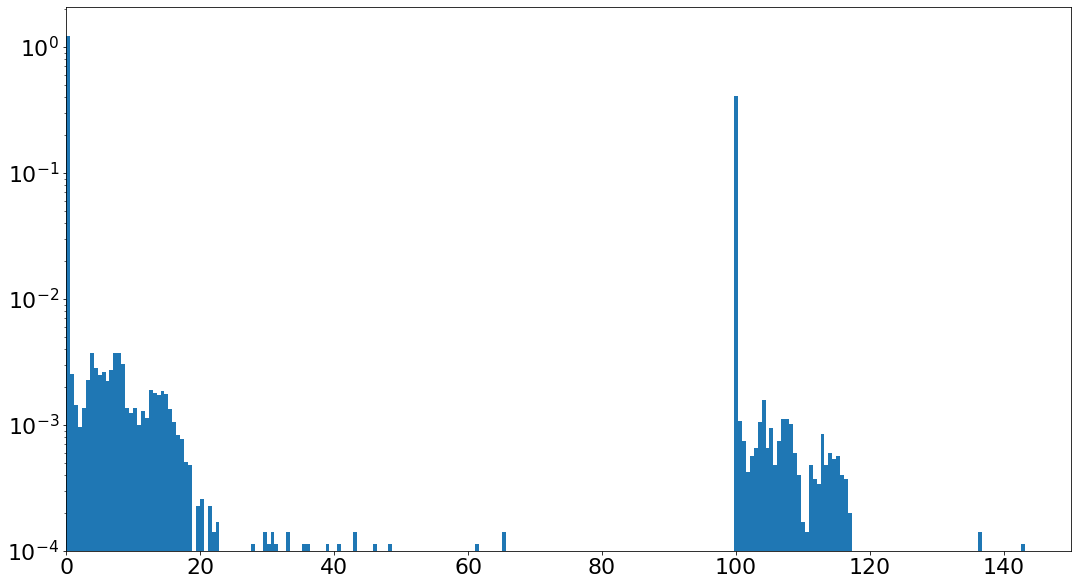

In [178]:
index = abs(signal_strengths - 100).argmin()
vals = observed[index, :]
plt.hist(vals, bins=300, density=True)
plt.yscale('log')
plt.xlim(0, 150)
plt.ylim(1e-4, None);

13446 points


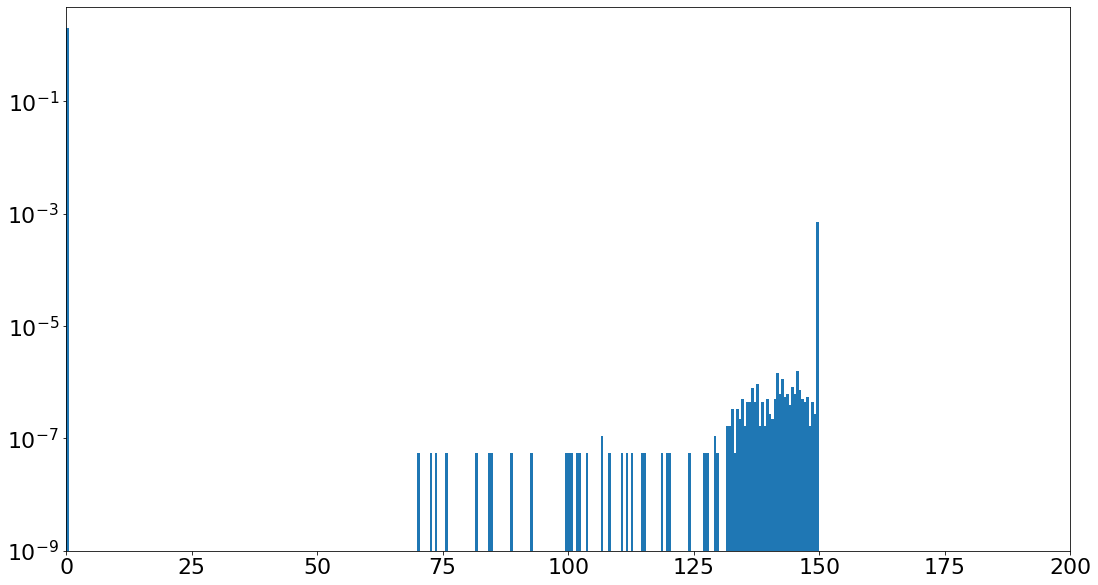

In [193]:
chosen_observation = 150
injected_locations = abs(observed - chosen_observation) < 0.08
print(injected_locations.sum(), 'points')
plt.hist((signal * injected_locations).flatten(), bins=300, density=True)
plt.yscale('log')
plt.xlim(signal_strengths[0], signal_strengths[-1])
plt.ylim(1e-9, None);